# ML on ESDC using TensorFlow 
A DeepESDL example notebook

## Linear Regression for prediction of missing land surface temperature values from air temperature values
This notebook demonstrates how to implement Machine Learning on the Earth System Data Cube using the ML library TensorFlow. The workflow is self-contained and based on a generic use case to showcase data loading, sampling strategies, model training, model evaluation and visualisation.

Please, also refer to the DeepESDL documentation and visit the platform's website for further information!

ScaDS.AI, 2023

### Import necessary libraries
In case you experience an error due to a missing library xy, please install it via "pip install yx".

In [3]:
import datetime, os
import xarray as xr
import dask.array as da
import numpy as np
import pandas as pd
from xcube.core.store import new_data_store
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K

from sklearn.metrics import r2_score, mean_squared_error
import mltools as ml

from global_land_mask import globe
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%load_ext tensorboard

2023-05-02 18:39:40.426045: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 18:39:45.267660: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Load Data (Earth System Data Cube)
We load the ESDC (*.zarr) from the s3 data store (lazy load). The ESDC consists of three dimensions (longitude, latitude, time). Out of many available cube variables, which are dask arrays, we load two ("land_surface_temperature", "air_temperature_2m"). 

In [3]:
data_store = new_data_store("s3", root="esdl-esdc-v2.1.1", storage_options=dict(anon=True))
dataset = data_store.open_data('esdc-8d-0.083deg-184x270x270-2.1.1.zarr')
ds = dataset[['land_surface_temperature', 'air_temperature_2m']]
ds

### Add land mask variable 
Here we exclude redundant water surface values for our use case and only consider solid Earth data for our ML analysis. We extend the ESDC by a new variable "land_mask". The mask is a data array initialized for one time slice of the ESDC. 

In [5]:
lon_grid, lat_grid = np.meshgrid(ds.lon,ds.lat)
lm0 = da.from_array(globe.is_land(lat_grid, lon_grid))
lm0

dask.array<array, shape=(2160, 4320), dtype=bool, chunksize=(2160, 4320), chunktype=numpy.ndarray>

We now extend the mask to all time slices of the ESDC.

In [6]:
lm = da.stack([lm0 for i in range(ds.dims['time'])], axis = 0)
lm

dask.array<stack, shape=(10, 2160, 4320), dtype=bool, chunksize=(1, 2160, 4320), chunktype=numpy.ndarray>

We add the mask as variable to the ESDC. The cube now consists of three equally chunked variables ("land_surface_temperature", "air_temperature_2m", "land_mask"). 

In [12]:
xdsm = ds.assign(land_mask= (['time','lat','lon'],lm.rechunk(chunks=([v for k,v in ml.get_chunk_sizes(ds)]))))
xdsm

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Plot masked data for one time slice
To do that we convert the cube to a pandas dataframe.

In [13]:
df = xdsm.sel({'time' : '2002-05-21'}).to_dataframe()
df

air_temperature_2m  land_surface_temperature  \
lat        lon                                                         
 89.958333 -179.958333          266.297180                       NaN   
           -179.875000          266.297180                       NaN   
           -179.791667          266.297180                       NaN   
           -179.708333          266.297180                       NaN   
           -179.625000          266.297180                       NaN   
...                                    ...                       ...   
-89.958333  179.625000          219.817398                       NaN   
            179.708333          219.817398                       NaN   
            179.791667          219.817398                       NaN   
            179.875000          219.817398                       NaN   
            179.958333          219.817398                       NaN   

                             time  land_mask  
lat        lon                                
 89.958333 -179.958333 2002-05-21      False  
           -179.875000 2002-05-21      False  
           -179.791667 2002-05-21      False  
           -179.708333 2002-05-21      False  
           -179.625000 2002-05-21      False  
...                           ...        ...  
-89.958333  179.625000 2002-05-21       True  
            179.708333 2002-05-21       True  
            179.791667 2002-05-21       True  
            179.875000 2002-05-21       True  
            179.958333 2002-05-21       True  

[9331200 rows x 4 columns]

Air Temperature

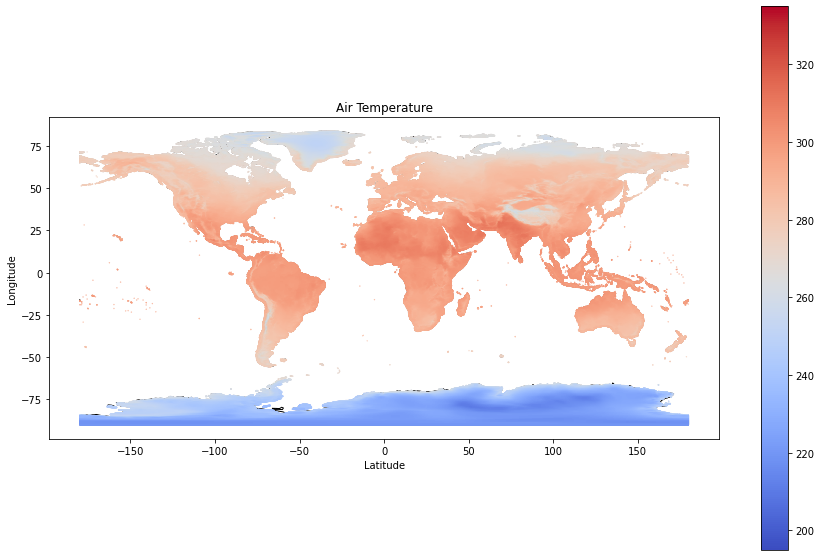

In [27]:
dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

geometry = [Point(xy) for xy in zip(dfdn['lon'], dfdn['lat'])]
gdf = GeoDataFrame(dfdn, geometry=geometry) 

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
        column = 'air_temperature_2m', cmap = 'coolwarm', legend = True, legend_kwds={
        "shrink":.5, 'label': 'Air Temperature [K]'});

plt.title('Air Temperature')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
#plt.savefig('air_temp_masked.png')

Land Surface Temperature

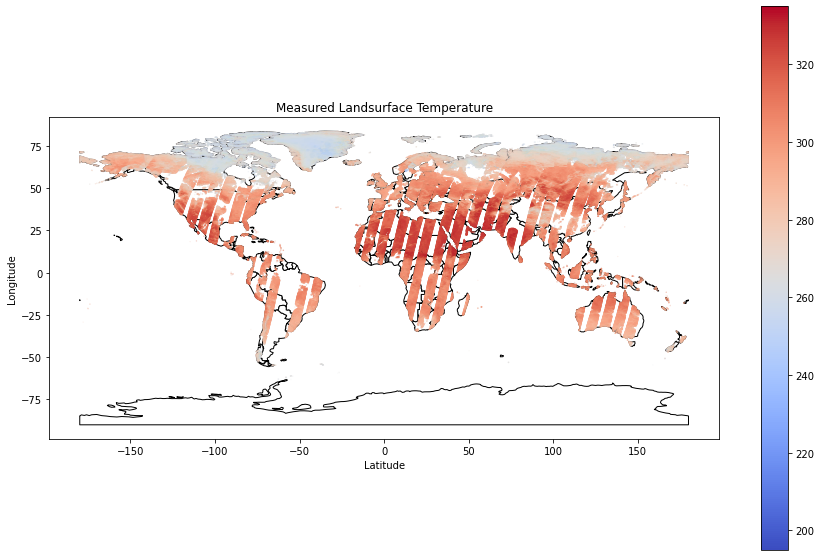

In [ ]:
dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

geometry = [Point(xy) for xy in zip(dfdn['lon'], dfdn['lat'])]
gdf = GeoDataFrame(dfdn, geometry=geometry) 

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
        column = 'land_surface_temperature', cmap = 'coolwarm', legend = True, legend_kwds={
        "shrink":.5, 'label': 'Land Surface Temperature [K]'});

plt.title('Land Surface Temperature')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
#plt.savefig('land_surface_temperature.png')

### Assign train/test split
Here you can choose between random sampling and block sampling. Based on the use case, the application of ML analyses on remotely sensed data is prone to autocorrelation, especially when the data is split randomly. Block sampling is one strategy to deal with autocorrelation.

In [14]:
# random sampling
#xds = ds.assign({"split": ml.rand})


# block sampling
xds = ml.assign_split(xdsm, block_size=[("time", 10), ("lat", 100), ("lon", 100)], split=0.7)
xds

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    split                     (time, lat, lon) float64 dask.array<chunksize=(10, 100, 100), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

Plot train/test assignment

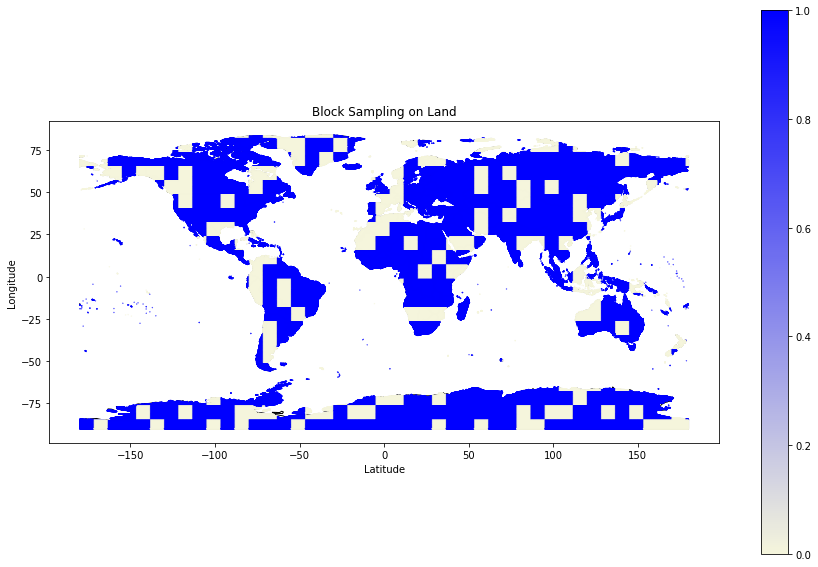

In [20]:
df = xds.sel({'time' : '2002-05-21'}).to_dataframe()

dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

geometry = [Point(xy) for xy in zip(dfdn['lon'], dfdn['lat'])]
gdf = GeoDataFrame(dfdn, geometry=geometry) 

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
    column = 'split', cmap = LinearSegmentedColormap.from_list("", ["beige","blue"]), legend = True, legend_kwds={
        "shrink":.5, 'label': 'train/test assignment', 'ticks': [0,1]}) 

plt.title('Block Sampling')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
#plt.savefig('train_test_assignment.png')

### Model set up

In [15]:
def create_model():
    inputs = L.Input(name="air_temperature_2m", shape=(1,))
    output = L.Dense(1, activation="linear", name="land_surface_temperature")(inputs)
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics="mae")
    return model

model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 air_temperature_2m (InputLa  [(None, 1)]              0         
 yer)                                                            
                                                                 
 land_surface_temperature (D  (None, 1)                2         
 ense)                                                           
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [16]:
K.set_value(model.optimizer.learning_rate, 0.0001)

Enable logging for Tensorboard

In [17]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

Get range (min, max) and statistics (mean, std) of data variables for normalization or standardization.

In [18]:
at_range = ml.getRange(xds, 'air_temperature_2m')
lst_range = ml.getRange(xds, 'land_surface_temperature')

at_stat = ml.getStatistics(xds, 'air_temperature_2m')
lst_stat = ml.getStatistics(xds, 'land_surface_temperature')

### Train model

We iterate through the chunks of the ESDC. The data will be preprocessed by flattening, choosing values, removing NaNs, normalization or standardization. Further, we will split the data into a training and testing fraction. We generate a train data loader and a test data loader and perform a linear regression. The train and test errors are returned during model training.

In [19]:
for chunk in ml.iter_data_var_blocks(xds): 
    ### preprocessing
    # flatten
    cf = {x: chunk[x].ravel() for x in chunk.keys()}
    # drop nans
    lst = cf['land_surface_temperature']
    cfn = {x: cf[x][~np.isnan(lst)] for x in cf.keys()}

    if len(cfn['land_surface_temperature']) > 0:
        X = ml.standardize(cfn['air_temperature_2m'],*at_stat)
        y = ml.standardize(cfn['land_surface_temperature'], *lst_stat)
        
        ### get train/test data
        X_train = X[cfn['split']==True]
        X_test  = X[cfn['split']==False]
        y_train = y[cfn['split']==True]
        y_test  = y[cfn['split']==False]
        
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
        
        ### train model
        model.fit(train_ds.batch(100).take(10000),validation_data=test_ds.batch(100).take(2000), epochs=3, callbacks=[tensorboard_callback])

Epoch 1/3


2023-05-02 18:45:26.033676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [314557]
	 [[{{node Placeholder/_1}}]]


3125/3146 [============================>.] - ETA: 0s - loss: 2.1202 - mae: 1.4090

2023-05-02 18:45:30.727297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [124833]
	 [[{{node Placeholder/_1}}]]


3146/3146 [==============================] - 6s 2ms/step - loss: 2.1100 - mae: 1.4047 - val_loss: 1.5294 - val_mae: 1.1946
Epoch 2/3
3146/3146 [==============================] - 5s 2ms/step - loss: 1.2095 - mae: 1.0557 - val_loss: 0.8108 - val_mae: 0.8636
Epoch 3/3
3146/3146 [==============================] - 5s 2ms/step - loss: 0.6027 - mae: 0.7311 - val_loss: 0.3731 - val_mae: 0.5680
Epoch 1/3
 115/4784 [..............................] - ETA: 6s - loss: 0.9220 - mae: 0.9483

2023-05-02 18:45:42.745067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [478378]
	 [[{{node Placeholder/_1}}]]


4784/4784 [==============================] - 7s 1ms/step - loss: 0.2980 - mae: 0.4491 - val_loss: 0.1400 - val_mae: 0.3424
Epoch 2/3
  39/4784 [..............................] - ETA: 6s - loss: 0.3716 - mae: 0.5928 

2023-05-02 18:45:49.246778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [9358]
	 [[{{node Placeholder/_1}}]]


4784/4784 [==============================] - 6s 1ms/step - loss: 0.1812 - mae: 0.2925 - val_loss: 0.0661 - val_mae: 0.2166
Epoch 3/3
4784/4784 [==============================] - 6s 1ms/step - loss: 0.1471 - mae: 0.2453 - val_loss: 0.0494 - val_mae: 0.1827
Epoch 1/3
 114/3704 [..............................] - ETA: 4s - loss: 0.1603 - mae: 0.3628

2023-05-02 18:46:02.325346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [370382]
	 [[{{node Placeholder/_1}}]]


3696/3704 [============================>.] - ETA: 0s - loss: 0.1550 - mae: 0.2556

2023-05-02 18:46:07.234428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [110983]
	 [[{{node Placeholder/_1}}]]


3704/3704 [==============================] - 6s 2ms/step - loss: 0.1551 - mae: 0.2560 - val_loss: 0.0639 - val_mae: 0.1896
Epoch 2/3
3704/3704 [==============================] - 6s 2ms/step - loss: 0.1317 - mae: 0.2388 - val_loss: 0.0567 - val_mae: 0.1807
Epoch 3/3
3704/3704 [==============================] - 6s 2ms/step - loss: 0.1111 - mae: 0.2201 - val_loss: 0.0491 - val_mae: 0.1684
Epoch 1/3
 113/4768 [..............................] - ETA: 6s - loss: 0.1484 - mae: 0.3719

2023-05-02 18:46:20.141645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [476721]
	 [[{{node Placeholder/_1}}]]


4762/4768 [============================>.] - ETA: 0s - loss: 0.0543 - mae: 0.1707

2023-05-02 18:46:26.510806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [23924]
	 [[{{node Placeholder/_1}}]]


4768/4768 [==============================] - 7s 1ms/step - loss: 0.0547 - mae: 0.1711 - val_loss: 0.0351 - val_mae: 0.1449
Epoch 2/3
4768/4768 [==============================] - 7s 1ms/step - loss: 0.0476 - mae: 0.1591 - val_loss: 0.0309 - val_mae: 0.1338
Epoch 3/3
4768/4768 [==============================] - 6s 1ms/step - loss: 0.0427 - mae: 0.1498 - val_loss: 0.0272 - val_mae: 0.1226
Epoch 1/3
 116/4030 [..............................] - ETA: 5s - loss: 0.0312 - mae: 0.1419

2023-05-02 18:46:39.954966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [402909]
	 [[{{node Placeholder/_1}}]]


4012/4030 [============================>.] - ETA: 0s - loss: 0.0576 - mae: 0.1853

2023-05-02 18:46:45.332938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [35083]
	 [[{{node Placeholder/_1}}]]


4030/4030 [==============================] - 6s 1ms/step - loss: 0.0579 - mae: 0.1859 - val_loss: 0.0595 - val_mae: 0.1890
Epoch 2/3
4030/4030 [==============================] - 6s 1ms/step - loss: 0.0579 - mae: 0.1868 - val_loss: 0.0595 - val_mae: 0.1888
Epoch 3/3
4030/4030 [==============================] - 6s 1ms/step - loss: 0.0574 - mae: 0.1860 - val_loss: 0.0595 - val_mae: 0.1882
Epoch 1/3
 115/1338 [=>............................] - ETA: 1s - loss: 0.0386 - mae: 0.1661

2023-05-02 18:46:57.139721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [133731]
	 [[{{node Placeholder/_1}}]]


1338/1338 [==============================] - ETA: 0s - loss: 0.0390 - mae: 0.1494

2023-05-02 18:46:58.937839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [278370]
	 [[{{node Placeholder/_1}}]]


1338/1338 [==============================] - 4s 3ms/step - loss: 0.0390 - mae: 0.1494 - val_loss: 0.0366 - val_mae: 0.1473
Epoch 2/3
1338/1338 [==============================] - 4s 3ms/step - loss: 0.0369 - mae: 0.1444 - val_loss: 0.0378 - val_mae: 0.1501
Epoch 3/3
1338/1338 [==============================] - 3s 3ms/step - loss: 0.0367 - mae: 0.1434 - val_loss: 0.0380 - val_mae: 0.1500
Epoch 1/3
 117/3086 [>.............................] - ETA: 3s - loss: 0.1162 - mae: 0.3197

2023-05-02 18:47:07.847147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [308521]
	 [[{{node Placeholder/_1}}]]


3049/3086 [============================>.] - ETA: 0s - loss: 0.0524 - mae: 0.1705

2023-05-02 18:47:12.034567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [201907]
	 [[{{node Placeholder/_1}}]]


3086/3086 [==============================] - 6s 2ms/step - loss: 0.0527 - mae: 0.1713 - val_loss: 0.0785 - val_mae: 0.2034
Epoch 2/3
3086/3086 [==============================] - 6s 2ms/step - loss: 0.0501 - mae: 0.1655 - val_loss: 0.0779 - val_mae: 0.2028
Epoch 3/3
3086/3086 [==============================] - 6s 2ms/step - loss: 0.0499 - mae: 0.1655 - val_loss: 0.0776 - val_mae: 0.2027
Epoch 1/3
 117/1537 [=>............................] - ETA: 1s - loss: 0.0291 - mae: 0.1350

2023-05-02 18:47:25.390453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [153608]
	 [[{{node Placeholder/_1}}]]


1505/1537 [============================>.] - ETA: 0s - loss: 0.0364 - mae: 0.1343

2023-05-02 18:47:27.435663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [47558]
	 [[{{node Placeholder/_1}}]]


1537/1537 [==============================] - 2s 2ms/step - loss: 0.0373 - mae: 0.1364 - val_loss: 0.0370 - val_mae: 0.1423
Epoch 2/3
1537/1537 [==============================] - 2s 2ms/step - loss: 0.0363 - mae: 0.1309 - val_loss: 0.0365 - val_mae: 0.1392
Epoch 3/3
1537/1537 [==============================] - 2s 2ms/step - loss: 0.0361 - mae: 0.1300 - val_loss: 0.0364 - val_mae: 0.1388
Epoch 1/3
116/708 [===>..........................] - ETA: 0s - loss: 0.0228 - mae: 0.1150

2023-05-02 18:47:32.954257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [70729]
	 [[{{node Placeholder/_1}}]]


692/708 [============================>.] - ETA: 0s - loss: 0.0349 - mae: 0.1344

2023-05-02 18:47:33.915350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [100048]
	 [[{{node Placeholder/_1}}]]


708/708 [==============================] - 2s 3ms/step - loss: 0.0356 - mae: 0.1362 - val_loss: 0.0295 - val_mae: 0.1210
Epoch 2/3
708/708 [==============================] - 2s 3ms/step - loss: 0.0335 - mae: 0.1270 - val_loss: 0.0288 - val_mae: 0.1181
Epoch 3/3
708/708 [==============================] - 2s 3ms/step - loss: 0.0325 - mae: 0.1229 - val_loss: 0.0285 - val_mae: 0.1172
Epoch 1/3
 116/1496 [=>............................] - ETA: 1s - loss: 0.0176 - mae: 0.1131

2023-05-02 18:47:38.549905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [149516]
	 [[{{node Placeholder/_1}}]]


1471/1496 [============================>.] - ETA: 0s - loss: 0.0190 - mae: 0.0926

2023-05-02 18:47:40.536769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [80438]
	 [[{{node Placeholder/_1}}]]


1496/1496 [==============================] - 3s 2ms/step - loss: 0.0202 - mae: 0.0944 - val_loss: 0.0627 - val_mae: 0.1889
Epoch 2/3
1496/1496 [==============================] - 3s 2ms/step - loss: 0.0200 - mae: 0.0938 - val_loss: 0.0636 - val_mae: 0.1902
Epoch 3/3
1496/1496 [==============================] - 3s 2ms/step - loss: 0.0200 - mae: 0.0941 - val_loss: 0.0638 - val_mae: 0.1904
Epoch 1/3
 117/1932 [>.............................] - ETA: 2s - loss: 0.0202 - mae: 0.1098

2023-05-02 18:47:46.752089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [193121]
	 [[{{node Placeholder/_1}}]]


1920/1932 [============================>.] - ETA: 0s - loss: 0.0398 - mae: 0.1369

2023-05-02 18:47:49.330410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [111865]
	 [[{{node Placeholder/_1}}]]


1932/1932 [==============================] - 4s 2ms/step - loss: 0.0408 - mae: 0.1381 - val_loss: 0.0301 - val_mae: 0.1311
Epoch 2/3
1932/1932 [==============================] - 4s 2ms/step - loss: 0.0406 - mae: 0.1383 - val_loss: 0.0302 - val_mae: 0.1314
Epoch 3/3
1932/1932 [==============================] - 3s 2ms/step - loss: 0.0405 - mae: 0.1384 - val_loss: 0.0303 - val_mae: 0.1316
Epoch 1/3
 116/2811 [>.............................] - ETA: 3s - loss: 0.0547 - mae: 0.1881

2023-05-02 18:47:57.587622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [281017]
	 [[{{node Placeholder/_1}}]]


2803/2811 [============================>.] - ETA: 0s - loss: 0.0542 - mae: 0.1745

2023-05-02 18:48:01.276334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [175337]
	 [[{{node Placeholder/_1}}]]


2811/2811 [==============================] - 5s 2ms/step - loss: 0.0543 - mae: 0.1747 - val_loss: 0.0304 - val_mae: 0.1308
Epoch 2/3
2811/2811 [==============================] - 5s 2ms/step - loss: 0.0539 - mae: 0.1757 - val_loss: 0.0308 - val_mae: 0.1318
Epoch 3/3
2811/2811 [==============================] - 5s 2ms/step - loss: 0.0539 - mae: 0.1758 - val_loss: 0.0305 - val_mae: 0.1312
Epoch 1/3
 120/3159 [>.............................] - ETA: 3s - loss: 0.0201 - mae: 0.1040

2023-05-02 18:48:13.317405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [315886]
	 [[{{node Placeholder/_1}}]]


3131/3159 [============================>.] - ETA: 0s - loss: 0.0746 - mae: 0.2073

2023-05-02 18:48:17.486199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [173460]
	 [[{{node Placeholder/_1}}]]


3159/3159 [==============================] - 6s 2ms/step - loss: 0.0745 - mae: 0.2074 - val_loss: 0.0462 - val_mae: 0.1655
Epoch 2/3
3159/3159 [==============================] - 6s 2ms/step - loss: 0.0718 - mae: 0.2058 - val_loss: 0.0465 - val_mae: 0.1664
Epoch 3/3
3159/3159 [==============================] - 6s 2ms/step - loss: 0.0710 - mae: 0.2046 - val_loss: 0.0462 - val_mae: 0.1654
Epoch 1/3
 116/3569 [..............................] - ETA: 4s - loss: 0.0224 - mae: 0.1161

2023-05-02 18:48:30.358048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [356886]
	 [[{{node Placeholder/_1}}]]


3554/3569 [============================>.] - ETA: 0s - loss: 0.0602 - mae: 0.1733

2023-05-02 18:48:35.113716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [101319]
	 [[{{node Placeholder/_1}}]]


3569/3569 [==============================] - 6s 2ms/step - loss: 0.0601 - mae: 0.1732 - val_loss: 0.0256 - val_mae: 0.1097
Epoch 2/3
3569/3569 [==============================] - 6s 2ms/step - loss: 0.0561 - mae: 0.1671 - val_loss: 0.0244 - val_mae: 0.1065
Epoch 3/3
3569/3569 [==============================] - 6s 2ms/step - loss: 0.0550 - mae: 0.1664 - val_loss: 0.0240 - val_mae: 0.1059
Epoch 1/3
 117/3139 [>.............................] - ETA: 3s - loss: 0.0245 - mae: 0.1364

2023-05-02 18:48:47.388855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [313883]
	 [[{{node Placeholder/_1}}]]


3110/3139 [============================>.] - ETA: 0s - loss: 0.0404 - mae: 0.1444

2023-05-02 18:48:51.509450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [151916]
	 [[{{node Placeholder/_1}}]]


3139/3139 [==============================] - 5s 2ms/step - loss: 0.0406 - mae: 0.1452 - val_loss: 0.0461 - val_mae: 0.1543
Epoch 2/3
3139/3139 [==============================] - 5s 2ms/step - loss: 0.0404 - mae: 0.1449 - val_loss: 0.0458 - val_mae: 0.1537
Epoch 3/3
3139/3139 [==============================] - 5s 2ms/step - loss: 0.0402 - mae: 0.1447 - val_loss: 0.0456 - val_mae: 0.1534
Epoch 1/3
 118/4283 [..............................] - ETA: 5s - loss: 0.0462 - mae: 0.1869

2023-05-02 18:49:03.754975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [428253]
	 [[{{node Placeholder/_1}}]]


4255/4283 [============================>.] - ETA: 0s - loss: 0.0325 - mae: 0.1320

2023-05-02 18:49:09.288677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [40015]
	 [[{{node Placeholder/_1}}]]


4283/4283 [==============================] - 6s 1ms/step - loss: 0.0326 - mae: 0.1323 - val_loss: 0.0371 - val_mae: 0.1424
Epoch 2/3
4283/4283 [==============================] - 6s 1ms/step - loss: 0.0327 - mae: 0.1327 - val_loss: 0.0374 - val_mae: 0.1428
Epoch 3/3
4283/4283 [==============================] - 6s 1ms/step - loss: 0.0326 - mae: 0.1323 - val_loss: 0.0377 - val_mae: 0.1433
Epoch 1/3
118/265 [============>.................] - ETA: 0s - loss: 0.1382 - mae: 0.2884

2023-05-02 18:49:21.571007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [26491]
	 [[{{node Placeholder/_1}}]]


237/265 [=========================>....] - ETA: 0s - loss: 0.1472 - mae: 0.3041

2023-05-02 18:49:21.938474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [93725]
	 [[{{node Placeholder/_1}}]]


265/265 [==============================] - 1s 4ms/step - loss: 0.1445 - mae: 0.3018 - val_loss: 0.1145 - val_mae: 0.2684
Epoch 2/3
265/265 [==============================] - 1s 4ms/step - loss: 0.1337 - mae: 0.2890 - val_loss: 0.1100 - val_mae: 0.2628
Epoch 3/3
265/265 [==============================] - 1s 4ms/step - loss: 0.1269 - mae: 0.2808 - val_loss: 0.1073 - val_mae: 0.2596
Epoch 1/3
 119/1293 [=>............................] - ETA: 1s - loss: 0.0782 - mae: 0.2245

2023-05-02 18:49:25.216549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [129288]
	 [[{{node Placeholder/_1}}]]


1279/1293 [============================>.] - ETA: 0s - loss: 0.1088 - mae: 0.2573

2023-05-02 18:49:26.931715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [105117]
	 [[{{node Placeholder/_1}}]]


1293/1293 [==============================] - 3s 2ms/step - loss: 0.1082 - mae: 0.2565 - val_loss: 0.1402 - val_mae: 0.2900
Epoch 2/3
1293/1293 [==============================] - 3s 2ms/step - loss: 0.1056 - mae: 0.2527 - val_loss: 0.1413 - val_mae: 0.2915
Epoch 3/3
1293/1293 [==============================] - 3s 2ms/step - loss: 0.1047 - mae: 0.2514 - val_loss: 0.1416 - val_mae: 0.2922
Epoch 1/3
 116/1804 [>.............................] - ETA: 2s - loss: 0.0531 - mae: 0.1888

2023-05-02 18:49:33.204420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [180329]
	 [[{{node Placeholder/_1}}]]


1803/1804 [============================>.] - ETA: 0s - loss: 0.1239 - mae: 0.2697

2023-05-02 18:49:35.563321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [288045]
	 [[{{node Placeholder/_1}}]]


1804/1804 [==============================] - 4s 2ms/step - loss: 0.1240 - mae: 0.2698 - val_loss: 0.1458 - val_mae: 0.2949
Epoch 2/3
1804/1804 [==============================] - 4s 2ms/step - loss: 0.1173 - mae: 0.2609 - val_loss: 0.1397 - val_mae: 0.2878
Epoch 3/3
1804/1804 [==============================] - 4s 2ms/step - loss: 0.1154 - mae: 0.2583 - val_loss: 0.1377 - val_mae: 0.2852
Epoch 1/3
 119/5107 [..............................] - ETA: 6s - loss: 0.1226 - mae: 0.3323

2023-05-02 18:49:45.438176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [510685]
	 [[{{node Placeholder/_1}}]]


5071/5107 [============================>.] - ETA: 0s - loss: 0.1615 - mae: 0.3006

2023-05-02 18:49:52.042758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [25658]
	 [[{{node Placeholder/_1}}]]


5107/5107 [==============================] - 7s 1ms/step - loss: 0.1612 - mae: 0.3004 - val_loss: 0.1222 - val_mae: 0.2783
Epoch 2/3
5107/5107 [==============================] - 7s 1ms/step - loss: 0.1552 - mae: 0.2936 - val_loss: 0.1311 - val_mae: 0.2931
Epoch 3/3
5107/5107 [==============================] - 7s 1ms/step - loss: 0.1533 - mae: 0.2906 - val_loss: 0.1368 - val_mae: 0.3020
Epoch 1/3
 119/2889 [>.............................] - ETA: 3s - loss: 0.0461 - mae: 0.1731

2023-05-02 18:50:06.241622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [288801]
	 [[{{node Placeholder/_1}}]]


2867/2889 [============================>.] - ETA: 0s - loss: 0.1189 - mae: 0.2635

2023-05-02 18:50:10.004485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [145312]
	 [[{{node Placeholder/_1}}]]


2889/2889 [==============================] - 5s 2ms/step - loss: 0.1196 - mae: 0.2645 - val_loss: 0.1553 - val_mae: 0.3059
Epoch 2/3
2889/2889 [==============================] - 5s 2ms/step - loss: 0.1168 - mae: 0.2578 - val_loss: 0.1590 - val_mae: 0.3101
Epoch 3/3
2889/2889 [==============================] - 5s 2ms/step - loss: 0.1161 - mae: 0.2563 - val_loss: 0.1602 - val_mae: 0.3120
Epoch 1/3
 119/1621 [=>............................] - ETA: 1s - loss: 0.0527 - mae: 0.1825

2023-05-02 18:50:21.466298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [162066]
	 [[{{node Placeholder/_1}}]]


1613/1621 [============================>.] - ETA: 0s - loss: 0.0985 - mae: 0.2358

2023-05-02 18:50:23.587296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [56134]
	 [[{{node Placeholder/_1}}]]


1621/1621 [==============================] - 3s 2ms/step - loss: 0.0993 - mae: 0.2366 - val_loss: 0.1013 - val_mae: 0.2478
Epoch 2/3
1621/1621 [==============================] - 3s 2ms/step - loss: 0.0938 - mae: 0.2284 - val_loss: 0.1027 - val_mae: 0.2529
Epoch 3/3
1621/1621 [==============================] - 3s 2ms/step - loss: 0.0926 - mae: 0.2271 - val_loss: 0.1039 - val_mae: 0.2557
Epoch 1/3
118/474 [======>.......................] - ETA: 0s - loss: 0.1064 - mae: 0.2670

2023-05-02 18:50:29.466436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [47378]
	 [[{{node Placeholder/_1}}]]


474/474 [==============================] - 1s 2ms/step - loss: 0.0891 - mae: 0.2371 - val_loss: 0.1222 - val_mae: 0.2850
Epoch 2/3
  1/474 [..............................] - ETA: 1s - loss: 0.1517 - mae: 0.3755

2023-05-02 18:50:30.105385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16552]
	 [[{{node Placeholder/_1}}]]


474/474 [==============================] - 1s 2ms/step - loss: 0.0870 - mae: 0.2347 - val_loss: 0.1177 - val_mae: 0.2791
Epoch 3/3
474/474 [==============================] - 1s 2ms/step - loss: 0.0854 - mae: 0.2328 - val_loss: 0.1143 - val_mae: 0.2744
Epoch 1/3
120/540 [=====>........................] - ETA: 0s - loss: 0.0828 - mae: 0.2178

2023-05-02 18:50:31.984011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [53968]
	 [[{{node Placeholder/_1}}]]


540/540 [==============================] - 1s 1ms/step - loss: 0.0789 - mae: 0.2122 - val_loss: 0.0732 - val_mae: 0.1976
Epoch 2/3
 39/540 [=>............................] - ETA: 0s - loss: 0.0787 - mae: 0.2080

2023-05-02 18:50:32.711636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [9427]
	 [[{{node Placeholder/_1}}]]


540/540 [==============================] - 1s 1ms/step - loss: 0.0787 - mae: 0.2117 - val_loss: 0.0729 - val_mae: 0.1967
Epoch 3/3
540/540 [==============================] - 1s 1ms/step - loss: 0.0785 - mae: 0.2111 - val_loss: 0.0725 - val_mae: 0.1958
Epoch 1/3
 118/2226 [>.............................] - ETA: 2s - loss: 0.3024 - mae: 0.4012

2023-05-02 18:50:34.599481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [222588]
	 [[{{node Placeholder/_1}}]]


2196/2226 [============================>.] - ETA: 0s - loss: 0.1022 - mae: 0.2326

2023-05-02 18:50:37.500230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [129203]
	 [[{{node Placeholder/_1}}]]


2226/2226 [==============================] - 4s 2ms/step - loss: 0.1016 - mae: 0.2321 - val_loss: 0.0753 - val_mae: 0.1991
Epoch 2/3
2226/2226 [==============================] - 4s 2ms/step - loss: 0.1007 - mae: 0.2339 - val_loss: 0.0753 - val_mae: 0.1996
Epoch 3/3
2226/2226 [==============================] - 4s 2ms/step - loss: 0.1006 - mae: 0.2343 - val_loss: 0.0753 - val_mae: 0.2000
Epoch 1/3
 118/5097 [..............................] - ETA: 6s - loss: 0.1771 - mae: 0.3451

2023-05-02 18:50:46.725604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [509649]
	 [[{{node Placeholder/_1}}]]


5095/5097 [============================>.] - ETA: 0s - loss: 0.1443 - mae: 0.2953

2023-05-02 18:50:53.449635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [41781]
	 [[{{node Placeholder/_1}}]]


5097/5097 [==============================] - 7s 1ms/step - loss: 0.1443 - mae: 0.2953 - val_loss: 0.1263 - val_mae: 0.2825
Epoch 2/3
5097/5097 [==============================] - 7s 1ms/step - loss: 0.1404 - mae: 0.2912 - val_loss: 0.1286 - val_mae: 0.2860
Epoch 3/3
5097/5097 [==============================] - 7s 1ms/step - loss: 0.1402 - mae: 0.2910 - val_loss: 0.1292 - val_mae: 0.2869
Epoch 1/3
 115/3662 [..............................] - ETA: 4s - loss: 0.1020 - mae: 0.2303

2023-05-02 18:51:08.054963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [366144]
	 [[{{node Placeholder/_1}}]]


3633/3662 [============================>.] - ETA: 0s - loss: 0.1914 - mae: 0.3528

2023-05-02 18:51:13.617823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [146075]
	 [[{{node Placeholder/_1}}]]


3662/3662 [==============================] - 7s 2ms/step - loss: 0.1924 - mae: 0.3539 - val_loss: 0.1421 - val_mae: 0.2962
Epoch 2/3
3662/3662 [==============================] - 6s 2ms/step - loss: 0.1867 - mae: 0.3492 - val_loss: 0.1413 - val_mae: 0.2959
Epoch 3/3
3662/3662 [==============================] - 6s 2ms/step - loss: 0.1855 - mae: 0.3476 - val_loss: 0.1412 - val_mae: 0.2958
Epoch 1/3
 118/3600 [..............................] - ETA: 4s - loss: 0.0431 - mae: 0.1593

2023-05-02 18:51:27.216103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [359960]
	 [[{{node Placeholder/_1}}]]


3571/3600 [============================>.] - ETA: 0s - loss: 0.1760 - mae: 0.3283

2023-05-02 18:51:31.941938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [172404]
	 [[{{node Placeholder/_1}}]]


3600/3600 [==============================] - 6s 2ms/step - loss: 0.1765 - mae: 0.3293 - val_loss: 0.1831 - val_mae: 0.3116
Epoch 2/3
3600/3600 [==============================] - 6s 2ms/step - loss: 0.1763 - mae: 0.3290 - val_loss: 0.1831 - val_mae: 0.3116
Epoch 3/3
3600/3600 [==============================] - 6s 2ms/step - loss: 0.1762 - mae: 0.3288 - val_loss: 0.1831 - val_mae: 0.3116
Epoch 1/3
  82/4742 [..............................] - ETA: 8s - loss: 0.0295 - mae: 0.1330

2023-05-02 18:51:45.964151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [474158]
	 [[{{node Placeholder/_1}}]]


4718/4742 [============================>.] - ETA: 0s - loss: 0.2381 - mae: 0.3912

2023-05-02 18:51:52.208013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [61614]
	 [[{{node Placeholder/_1}}]]


4742/4742 [==============================] - 7s 1ms/step - loss: 0.2390 - mae: 0.3922 - val_loss: 0.2869 - val_mae: 0.4211
Epoch 2/3
4742/4742 [==============================] - 7s 1ms/step - loss: 0.2394 - mae: 0.3896 - val_loss: 0.2900 - val_mae: 0.4230
Epoch 3/3
4742/4742 [==============================] - 7s 1ms/step - loss: 0.2396 - mae: 0.3891 - val_loss: 0.2903 - val_mae: 0.4231
Epoch 1/3
 117/5043 [..............................] - ETA: 6s - loss: 0.1636 - mae: 0.3234

2023-05-02 18:52:06.646108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [504221]
	 [[{{node Placeholder/_1}}]]


5042/5043 [============================>.] - ETA: 0s - loss: 0.1405 - mae: 0.2903

2023-05-02 18:52:13.266465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [22462]
	 [[{{node Placeholder/_1}}]]


5043/5043 [==============================] - 7s 1ms/step - loss: 0.1405 - mae: 0.2903 - val_loss: 0.4870 - val_mae: 0.5679
Epoch 2/3
5043/5043 [==============================] - 7s 1ms/step - loss: 0.1401 - mae: 0.2900 - val_loss: 0.4964 - val_mae: 0.5755
Epoch 3/3
5043/5043 [==============================] - 7s 1ms/step - loss: 0.1388 - mae: 0.2884 - val_loss: 0.4994 - val_mae: 0.5781
Epoch 1/3
 119/2257 [>.............................] - ETA: 2s - loss: 0.0988 - mae: 0.2430

2023-05-02 18:52:27.314367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [225621]
	 [[{{node Placeholder/_1}}]]


2234/2257 [============================>.] - ETA: 0s - loss: 0.1550 - mae: 0.3171

2023-05-02 18:52:30.257846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [38352]
	 [[{{node Placeholder/_1}}]]


2257/2257 [==============================] - 3s 1ms/step - loss: 0.1539 - mae: 0.3156 - val_loss: 0.1221 - val_mae: 0.2816
Epoch 2/3
2257/2257 [==============================] - 3s 1ms/step - loss: 0.1527 - mae: 0.3143 - val_loss: 0.1197 - val_mae: 0.2783
Epoch 3/3
2257/2257 [==============================] - 3s 1ms/step - loss: 0.1523 - mae: 0.3139 - val_loss: 0.1184 - val_mae: 0.2764
Epoch 1/3
 117/1944 [>.............................] - ETA: 2s - loss: 0.0302 - mae: 0.1352

2023-05-02 18:52:37.381825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [194397]
	 [[{{node Placeholder/_1}}]]


1944/1944 [==============================] - 3s 1ms/step - loss: 0.1105 - mae: 0.2684 - val_loss: 0.1910 - val_mae: 0.3606
Epoch 2/3
   1/1944 [..............................] - ETA: 6s - loss: 0.0130 - mae: 0.0944

2023-05-02 18:52:39.933040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16982]
	 [[{{node Placeholder/_1}}]]


1944/1944 [==============================] - 3s 1ms/step - loss: 0.1055 - mae: 0.2577 - val_loss: 0.2018 - val_mae: 0.3709
Epoch 3/3
1944/1944 [==============================] - 3s 1ms/step - loss: 0.1044 - mae: 0.2544 - val_loss: 0.2062 - val_mae: 0.3751
Epoch 1/3
 118/1025 [==>...........................] - ETA: 1s - loss: 0.7239 - mae: 0.7574

2023-05-02 18:52:45.905938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [102403]
	 [[{{node Placeholder/_1}}]]


1015/1025 [============================>.] - ETA: 0s - loss: 0.3735 - mae: 0.5069

2023-05-02 18:52:47.265491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [48725]
	 [[{{node Placeholder/_1}}]]


1025/1025 [==============================] - 2s 2ms/step - loss: 0.3733 - mae: 0.5071 - val_loss: 0.5928 - val_mae: 0.6819
Epoch 2/3
1025/1025 [==============================] - 2s 2ms/step - loss: 0.2496 - mae: 0.3996 - val_loss: 0.4592 - val_mae: 0.5849
Epoch 3/3
1025/1025 [==============================] - 2s 2ms/step - loss: 0.1990 - mae: 0.3525 - val_loss: 0.3816 - val_mae: 0.5229
Epoch 1/3
 112/3104 [>.............................] - ETA: 4s - loss: 0.3949 - mae: 0.5301

2023-05-02 18:52:51.391111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [310313]
	 [[{{node Placeholder/_1}}]]


3079/3104 [============================>.] - ETA: 0s - loss: 0.2308 - mae: 0.3960

2023-05-02 18:52:55.499137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [117384]
	 [[{{node Placeholder/_1}}]]


3104/3104 [==============================] - 5s 2ms/step - loss: 0.2304 - mae: 0.3957 - val_loss: 0.2101 - val_mae: 0.3706
Epoch 2/3
3104/3104 [==============================] - 5s 2ms/step - loss: 0.2297 - mae: 0.3955 - val_loss: 0.2057 - val_mae: 0.3663
Epoch 3/3
3104/3104 [==============================] - 5s 2ms/step - loss: 0.2278 - mae: 0.3941 - val_loss: 0.2039 - val_mae: 0.3647
Epoch 1/3
 116/1972 [>.............................] - ETA: 2s - loss: 0.2030 - mae: 0.4263

2023-05-02 18:53:06.898347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [197199]
	 [[{{node Placeholder/_1}}]]


1972/1972 [==============================] - 3s 1ms/step - loss: 0.1472 - mae: 0.3035 - val_loss: 0.0863 - val_mae: 0.2232
Epoch 2/3
   1/1972 [..............................] - ETA: 5s - loss: 0.3147 - mae: 0.4692

2023-05-02 18:53:09.510672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [14211]
	 [[{{node Placeholder/_1}}]]


1972/1972 [==============================] - 3s 1ms/step - loss: 0.0994 - mae: 0.2265 - val_loss: 0.0755 - val_mae: 0.2001
Epoch 3/3
1972/1972 [==============================] - 3s 1ms/step - loss: 0.0977 - mae: 0.2227 - val_loss: 0.0777 - val_mae: 0.2019
Epoch 1/3
36/36 [==============================] - 0s 2ms/step - loss: 0.0841 - mae: 0.2030
Epoch 2/3
36/36 [==============================] - 0s 2ms/step - loss: 0.0840 - mae: 0.2027
Epoch 3/3
 1/36 [..............................] - ETA: 0s - loss: 0.1797 - mae: 0.4024

2023-05-02 18:53:15.267803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [3563]
	 [[{{node Placeholder/_1}}]]
2023-05-02 18:53:15.340435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [0]
	 [[{{node Placeholder/_1}}]]


36/36 [==============================] - 0s 2ms/step - loss: 0.0839 - mae: 0.2024
Epoch 1/3


2023-05-02 18:53:15.653364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [0]
	 [[{{node Placeholder/_1}}]]


ValueError: Unexpected result of `train_function` (Empty logs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

### Model Predictions

Get Air Temperature values for Lon/Lat with missing Land Surface Temperature values

In [20]:
df = xds.sel({'time' : '2002-05-21'}).to_dataframe()
df

air_temperature_2m  land_surface_temperature  \
lat        lon                                                         
 89.958333 -179.958333          266.297180                       NaN   
           -179.875000          266.297180                       NaN   
           -179.791667          266.297180                       NaN   
           -179.708333          266.297180                       NaN   
           -179.625000          266.297180                       NaN   
...                                    ...                       ...   
-89.958333  179.625000          219.817398                       NaN   
            179.708333          219.817398                       NaN   
            179.791667          219.817398                       NaN   
            179.875000          219.817398                       NaN   
            179.958333          219.817398                       NaN   

                             time  land_mask  split  
lat        lon                                       
 89.958333 -179.958333 2002-05-21      False    0.0  
           -179.875000 2002-05-21      False    0.0  
           -179.791667 2002-05-21      False    0.0  
           -179.708333 2002-05-21      False    0.0  
           -179.625000 2002-05-21      False    0.0  
...                           ...        ...    ...  
-89.958333  179.625000 2002-05-21       True    0.0  
            179.708333 2002-05-21       True    0.0  
            179.791667 2002-05-21       True    0.0  
            179.875000 2002-05-21       True    0.0  
            179.958333 2002-05-21       True    0.0  

[9331200 rows x 5 columns]

In [ ]:
Predict missing Land Surface Temperature values from Air Temperature values

In [21]:
dfl = df[df['land_mask'] == True]
orig = dfl.dropna()
to_pred = dfl[np.isnan(dfl['land_surface_temperature'])]
output = to_pred.drop('land_surface_temperature', axis = 1)

X = ml.standardize(to_pred['air_temperature_2m'], *at_stat)
X = X.values

lstp = model.predict(X.reshape(-1, 1))
output['land_surface_temperature'] = ml.undo_standardizing(lstp, *at_stat)
output

54346/54346 [==============================] - 46s 844us/step


air_temperature_2m       time  land_mask  split  \
lat        lon                                                            
 83.208333 -73.958333           266.152954 2002-05-21       True    1.0   
 83.125000 -77.041667           265.867096 2002-05-21       True    1.0   
           -76.958333           265.832367 2002-05-21       True    1.0   
           -76.875000           265.832367 2002-05-21       True    1.0   
           -76.791667           265.832367 2002-05-21       True    1.0   
...                                    ...        ...        ...    ...   
-89.958333  179.625000          219.817398 2002-05-21       True    0.0   
            179.708333          219.817398 2002-05-21       True    0.0   
            179.791667          219.817398 2002-05-21       True    0.0   
            179.875000          219.817398 2002-05-21       True    0.0   
            179.958333          219.817398 2002-05-21       True    0.0   

                        land_surface_temperature  
lat        lon                                    
 83.208333 -73.958333                 253.439819  
 83.125000 -77.041667                 253.042053  
           -76.958333                 252.993729  
           -76.875000                 252.993729  
           -76.791667                 252.993729  
...                                          ...  
-89.958333  179.625000                188.963593  
            179.708333                188.963593  
            179.791667                188.963593  
            179.875000                188.963593  
            179.958333                188.963593  

[1739067 rows x 5 columns]

### Plot Predictions

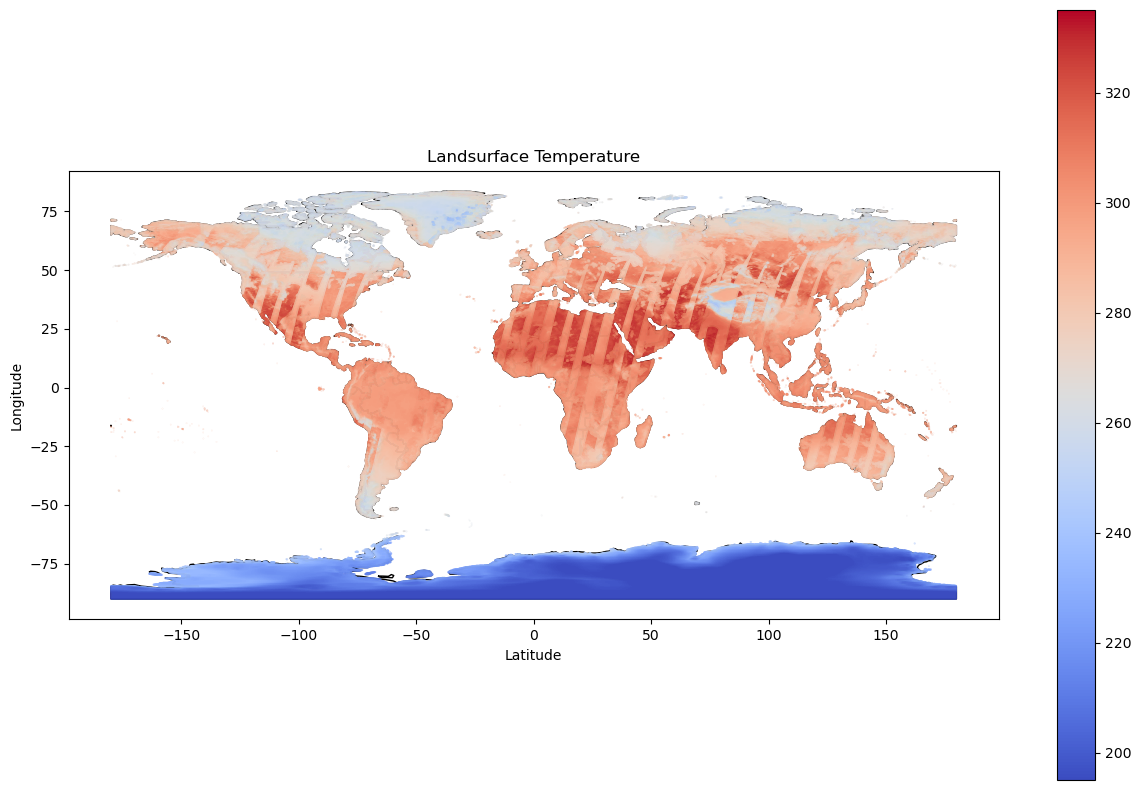

In [23]:
df = pd.concat([orig['land_surface_temperature'], output['land_surface_temperature']])
lst = df.reset_index()

geometry = [Point(xy) for xy in zip(lst['lon'], lst['lat'])]
gdf = GeoDataFrame(lst, geometry=geometry) 

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
        column = 'land_surface_temperature', cmap = 'coolwarm', legend = True, legend_kwds={
        "shrink":.5, 'label': 'Land Surface Temperature [K]'});

plt.title('Landsurface Temperature');
plt.xlabel('Latitude');
plt.ylabel('Longitude');
#fname = 'xxx' +'.png'
#plt.savefig(fname)
plt.show()

## Launching Tensorboard UI

In [37]:
#launching tensorboard
# currently not working in the jupyterhub
%tensorboard --logdir logs